In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Load the data
train_csv_path = '/content/drive/MyDrive/APS360 Group Project/train_malicious_phish.csv'
val_csv_path = '/content/drive/MyDrive/APS360 Group Project/val_malicious_phish.csv'
train_df = pd.read_csv(train_csv_path)
val_df = pd.read_csv(val_csv_path)

# Convert 'TRUE'/'FALSE' to 1/0
bool_columns = ['at_symbol_0', 'at_symbol_1', 'redirection_0', 'redirection_1',
                'has_ip_0', 'has_ip_1', 'has_https_0', 'has_https_1',
                'is_tinyurl_0', 'is_tinyurl_1']

for col in bool_columns:
    train_df[col] = train_df[col].apply(lambda x: 1 if x == 'TRUE' else 0)
    val_df[col] = val_df[col].apply(lambda x: 1 if x == 'TRUE' else 0)

# Separate features and labels
X_train = train_df.drop(columns=['type', 'url']).values
y_train = train_df['type'].values

X_val = val_df.drop(columns=['type', 'url']).values
y_val = val_df['type'].values

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class MaliciousURLCNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MaliciousURLCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.3)  # Dropout layer with 30% probability

        # Calculate the correct input size for the first fully connected layer
        self.fc1_input_size = self._calculate_fc1_input_size(input_size)
        self.fc1 = nn.Linear(self.fc1_input_size, 100)
        self.fc2 = nn.Linear(100, num_classes)

    def _calculate_fc1_input_size(self, input_size):
        # Assuming two pooling layers that reduce the input size by a factor of 2 each
        size_after_conv = input_size
        size_after_pool1 = size_after_conv // 2
        size_after_pool2 = size_after_pool1 // 2
        return 64 * size_after_pool2  # 64 channels after the second conv layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Assuming input_size is the number of features in your training data
input_size = X_train.shape[1]
num_classes = len(label_encoder.classes_)
model = MaliciousURLCNN(input_size, num_classes).to(device)

In [ ]:
import torch.optim as optim
import joblib

# Set device
use_cuda = True
device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
model.to(device)

if use_cuda and torch.cuda.is_available():
    print('CUDA is available! Training on GPU ...')
else:
    print('CUDA is not available. Training on CPU ...')

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    iters = []
    losses = []
    train_acc = []
    val_acc = []
    n_iter = 0

    for epoch in range(num_epochs):
        model.train()
        correct = 0
        total = 0
        epoch_loss = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.unsqueeze(1).to(device), labels.to(device)  # Add channel dimension

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = correct / total
        val_accuracy = get_accuracy(model, val_loader)

        # Track loss and accuracy for each epoch
        iters.append(n_iter)
        losses.append(epoch_loss / total)
        train_acc.append(train_accuracy)
        val_acc.append(val_accuracy)

        n_iter += 1

        val_accuracy = get_accuracy(model, val_loader)
        val_acc.append(val_accuracy)

        print(f'Epoch {epoch+1}, Loss: {epoch_loss/total:}, Train Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}')

    return iters, losses, train_acc, val_acc

# Evaluation function
def get_accuracy(model, val_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.unsqueeze(1).to(device), labels.to(device)  # Add channel dimension
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

# Train the model
num_epochs = 50
iters, losses, train_acc, val_acc = train(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)

# Save the trained model
torch.save(model.state_dict(), '/content/drive/MyDrive/APS360 Group Project/best_cnn_model.pth')

# Save the label encoder
joblib.dump(label_encoder, '/content/drive/MyDrive/APS360 Group Project/label_encoder.pkl')


CUDA is available! Training on GPU ...
Epoch 1, Loss: 0.004847158376750413, Train Accuracy: 0.7731806385233189, Validation Accuracy: 0.7961670467371524
Epoch 2, Loss: 0.004111104261902795, Train Accuracy: 0.8013790138054946, Validation Accuracy: 0.8064327889495466
Epoch 3, Loss: 0.00396582532259492, Train Accuracy: 0.8052872433544741, Validation Accuracy: 0.8075921958860249
Epoch 4, Loss: 0.0039017462322656076, Train Accuracy: 0.8089689645111258, Validation Accuracy: 0.8118305576670583
Epoch 5, Loss: 0.0038664713882931687, Train Accuracy: 0.810604431886239, Validation Accuracy: 0.8122758927817321
Epoch 6, Loss: 0.0038381669411823045, Train Accuracy: 0.811568052334956, Validation Accuracy: 0.8134199433349457
Epoch 7, Loss: 0.0038208465595695627, Train Accuracy: 0.8121477602543037, Validation Accuracy: 0.8122835709733643
Epoch 8, Loss: 0.0038111976696585835, Train Accuracy: 0.812831124556581, Validation Accuracy: 0.8145102465467333
Epoch 9, Loss: 0.0037992704838702425, Train Accuracy: 0.

['/content/drive/MyDrive/APS360 Group Project/label_encoder.pkl']

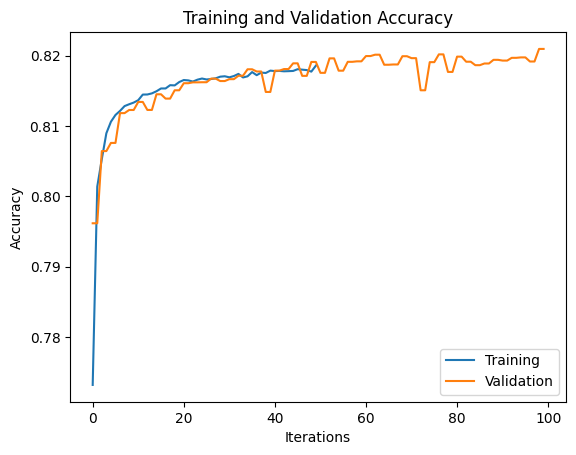

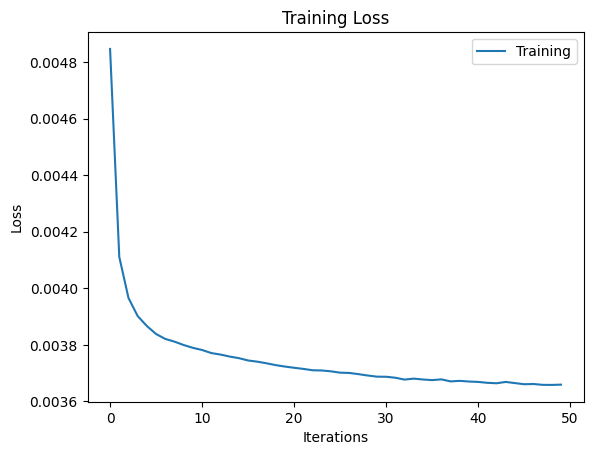

Final Training Accuracy: 0.8185782951212396
Final Validation Accuracy: 0.820959927517871
Final Loss: 0.0036590333045925737


In [ ]:
import matplotlib.pyplot as plt

# Accuracy Plot


plt.title("Training and Validation Accuracy")
plt.plot(train_acc, label='Training')
plt.plot(val_acc, label='Validation')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss Plot
plt.title('Training Loss')
plt.plot(losses, label='Training')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

print("Final Training Accuracy: {}".format(train_acc[-1]))
print("Final Validation Accuracy: {}".format(val_acc[-1]))
print("Final Loss: {}".format(losses[-1]))

In [ ]:
import re
from urllib.parse import urlparse
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
train_df = pd.read_csv('/content/drive/MyDrive/APS360 Group Project/train_malicious_phish.csv')
test_csv_path = '/content/drive/MyDrive/APS360 Group Project/URL_dataset_test.csv'
test_df = pd.read_csv(test_csv_path)

print(train_df.head())
print(test_df.head())

# Fit the MinMaxScaler on the training data
scaler = MinMaxScaler()
scaler.fit(train_df[['url_length', 'subdomains', 'word_count']])

def extract_features(url, scaler):
    # Feature: URL length
    url_length = len(url)

    # Feature: Subdomains count
    parsed_url = urlparse(url)
    subdomains = parsed_url.netloc.split('.')
    subdomain_count = len(subdomains) - 2  # -2 for domain name and top-level domain

    # Feature: Word count in URL path
    path_words = re.split(r'/|_|-|\.', parsed_url.path)
    word_count = len([word for word in path_words if word])

    # Normalize the features using the fitted scaler
    features_df = pd.DataFrame([[url_length, subdomain_count, word_count]], columns=['url_length', 'subdomains', 'word_count'])
    normalized_features = scaler.transform(features_df)[0]

    # Feature: Presence of '@' symbol
    at_symbol = '@' in url

    # Feature: Redirection ('//' in path)
    redirection = '//' in parsed_url.path

    # Feature: Presence of IP address
    ip_pattern = re.compile(r'(\d{1,3}\.){3}\d{1,3}')
    has_ip = bool(ip_pattern.match(parsed_url.netloc))

    # Feature: Uses HTTPS
    has_https = parsed_url.scheme == 'https'

    # Feature: Is TinyURL (example of a tiny URL domain)
    tinyurl_domains = ['bit.ly', 'goo.gl', 'tinyurl.com']
    is_tinyurl = parsed_url.netloc in tinyurl_domains

    # Combine all features into a single list
    features = {
        'url': url,                           # Include the original URL
        'url_length': normalized_features[0],  # Normalized url_length
        'subdomains': normalized_features[1],  # Normalized subdomain_count
        'word_count': normalized_features[2],  # Normalized word_count
        'at_symbol_0': int(not at_symbol),     # Complement of at_symbol
        'at_symbol_1': int(at_symbol),         # Convert boolean to int
        'redirection_0': int(not redirection), # Complement of redirection
        'redirection_1': int(redirection),     # Convert boolean to int
        'has_ip_0': int(not has_ip),           # Complement of has_ip
        'has_ip_1': int(has_ip),               # Convert boolean to int
        'has_https_0': int(not has_https),     # Complement of has_https
        'has_https_1': int(has_https),         # Convert boolean to int
        'is_tinyurl_0': int(not is_tinyurl),   # Complement of is_tinyurl
        'is_tinyurl_1': int(is_tinyurl)        # Convert boolean to int
    }

    return features

# Extract features for all URLs in the test dataset
features_list = []
for url in test_df['url']:
    features = extract_features(url, scaler)
    features_list.append(features)

# Create a DataFrame with the extracted features
features_df = pd.DataFrame(features_list)
features_df['type'] = test_df['type']  # Add the target column

# Save the processed data to a CSV file
features_df.to_csv('/content/drive/MyDrive/APS360 Group Project/processed_test_dataset.csv', index=False)


                                          url      type  url_length  \
0    en.wikipedia.org/wiki/United_States_Note    benign    0.017939   
1                  tools.ietf.org/html/rfc748  phishing    0.011500   
2              en.wikipedia.org/wiki/Eastview    benign    0.013339   
3  qvlivestreaming.com/wp-includes/css/remax/    benign    0.018859   
4                   smokemeatpete.com/Map.htm    benign    0.011040   

   subdomains  word_count  at_symbol_0  at_symbol_1  redirection_0  \
0         0.0    0.017301         True        False           True   
1         0.0    0.017301         True        False           True   
2         0.0    0.017301         True        False           True   
3         0.0    0.020761         True        False           True   
4         0.0    0.013841         True        False           True   

   redirection_1  has_ip_0  has_ip_1  has_https_0  has_https_1  is_tinyurl_0  \
0          False      True     False         True        False          

In [ ]:
import re
from urllib.parse import urlparse
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import joblib
from sklearn.preprocessing import MinMaxScaler

# Set device
use_cuda = True
device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")

train_csv_path = '/content/drive/MyDrive/APS360 Group Project/train_malicious_phish.csv'
train_df = pd.read_csv(train_csv_path)

# Fit the MinMaxScaler on the training data
scaler = MinMaxScaler()
scaler.fit(train_df[['url_length', 'subdomains', 'word_count']])

def extract_features(url, scaler):
    # Feature: URL length
    url_length = len(url)

    # Feature: Subdomains count
    parsed_url = urlparse(url)
    subdomains = parsed_url.netloc.split('.')
    subdomain_count = len(subdomains)

    # Feature: Word count in URL path
    path_words = re.split(r'/|_|-|\.', parsed_url.path)
    word_count = len([word for word in path_words if word])

    # Normalize the features using the fitted scaler
    normalized_features = scaler.transform([[url_length, subdomain_count, word_count]])[0]

    # Feature: Presence of '@' symbol
    at_symbol = '@' in url

    # Feature: Redirection ('//' in path)
    redirection = '//' in parsed_url.path

    # Feature: Presence of IP address
    ip_pattern = re.compile(r'(\d{1,3}\.){3}\d{1,3}')
    has_ip = bool(ip_pattern.match(parsed_url.netloc))

    # Feature: Uses HTTPS
    has_https = parsed_url.scheme == 'https'

    # Feature: Is TinyURL (example of a tiny URL domain)
    tinyurl_domains = ['bit.ly', 'goo.gl', 'tinyurl.com']
    is_tinyurl = parsed_url.netloc in tinyurl_domains

    # Combine all features into a single list
    features = [
        normalized_features[0],  # Normalized url_length
        normalized_features[1],  # Normalized subdomain_count
        normalized_features[2],  # Normalized word_count
        int(at_symbol),          # Convert boolean to int
        int(not at_symbol),      # Complement of at_symbol
        int(redirection),        # Convert boolean to int
        int(not redirection),    # Complement of redirection
        int(has_ip),             # Convert boolean to int
        int(not has_ip),         # Complement of has_ip
        int(has_https),          # Convert boolean to int
        int(not has_https),      # Complement of has_https
        int(is_tinyurl),         # Convert boolean to int
        int(not is_tinyurl)      # Complement of is_tinyurl
    ]

    return features

# Print the features
url = "coherent.com/products/?1485/Silhouette-Ultrafast-Pulse-Shaper"
features = extract_features(url, scaler)
print(features)

class MaliciousURLCNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MaliciousURLCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.3)  # Dropout layer with 30% probability
        self.fc1 = nn.Linear(192, 100)  # Adjust based on actual output size after conv2 and pool
        self.fc2 = nn.Linear(100, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout after the first fully connected layer
        x = self.fc2(x)
        return x

# Assuming input_size and num_classes are known
input_size = 13  # Number of features (3 normalized features + 10 boolean features)
num_classes = 4  # Number of classes, e.g., benign, phishing, malware, defacement

# Create a model instance with the correct input size
model = MaliciousURLCNN(input_size, num_classes).to(device)

# Load the model
model_path = '/content/drive/MyDrive/APS360 Group Project/best_cnn_model.pth'
model.load_state_dict(torch.load(model_path))
model.eval()

# Load the label encoder
label_encoder_path = '/content/drive/MyDrive/APS360 Group Project/label_encoder.pkl'
label_encoder = joblib.load(label_encoder_path)

# Function to predict if a URL is malicious
def predict_url(url, model, encoder):
    features = extract_features(url, scaler)
    features_tensor = torch.tensor(features, dtype=torch.float32).unsqueeze(0).unsqueeze(1).to(device)  # Add batch and channel dimensions

    model.eval()
    with torch.no_grad():
        output = model(features_tensor)
        _, predicted = torch.max(output.data, 1)
        predicted_label = encoder.inverse_transform(predicted.cpu().numpy())[0]

    return predicted_label

# Example usage
url_to_predict = "coherent.com/products/?1485/Silhouette-Ultrafast-Pulse-Shaper"
prediction = predict_url(url_to_predict, model, label_encoder)
print(f"The URL '{url_to_predict}' is classified as: {prediction}")

[63.75673076923076, 1.0, 3.0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
The URL 'coherent.com/products/?1485/Silhouette-Ultrafast-Pulse-Shaper' is classified as: phishing


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [ ]:
import re
from urllib.parse import urlparse
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib

# Load the training dataset
train_df = pd.read_csv('/content/drive/MyDrive/APS360 Group Project/train_malicious_phish.csv')

# Extract features and add them to the DataFrame
def extract_initial_features(df):
    url_lengths = []
    subdomain_counts = []
    word_counts = []

    for url in df['url']:
        # URL length
        url_lengths.append(len(url))

        # Subdomains count
        parsed_url = urlparse(url)
        subdomains = parsed_url.netloc.split('.')
        subdomain_counts.append(len(subdomains) - 2)  # -2 for domain name and top-level domain

        # Word count in URL path
        path_words = re.split(r'/|_|-|\.', parsed_url.path)
        word_counts.append(len([word for word in path_words if word]))

    df['url_length'] = url_lengths
    df['subdomains'] = subdomain_counts
    df['word_count'] = word_counts

    return df

# Apply the feature extraction to the training dataset
train_df = extract_initial_features(train_df)

# Fit the MinMaxScaler on the extracted features
scaler = MinMaxScaler()
scaler.fit(train_df[['url_length', 'subdomains', 'word_count']])

# Save the fitted scaler for later use
scaler_filename = 'scaler.pkl'
joblib.dump(scaler, scaler_filename)

print(f"Scaler fitted and saved to: {scaler_filename}")

# Load the scaler for later use
scaler = joblib.load(scaler_filename)

# Load the test dataset
test_df = pd.read_csv('/content/drive/MyDrive/APS360 Group Project/URL_dataset_test.csv')

# Function to extract and normalize features from a single URL
def extract_features(url, scaler):
    # Feature: URL length
    url_length = len(url)

    # Feature: Subdomains count
    parsed_url = urlparse(url)
    subdomains = parsed_url.netloc.split('.')
    subdomain_count = len(subdomains) - 2  # -2 for domain name and top-level domain

    # Feature: Word count in URL path
    path_words = re.split(r'/|_|-|\.', parsed_url.path)
    word_count = len([word for word in path_words if word])

    # Normalize the features using the fitted scaler
    features_df = pd.DataFrame([[url_length, subdomain_count, word_count]], columns=['url_length', 'subdomains', 'word_count'])
    normalized_features = scaler.transform(features_df)[0]

    # Feature: Presence of '@' symbol
    at_symbol = '@' in url

    # Feature: Redirection ('//' in path)
    redirection = '//' in parsed_url.path

    # Feature: Presence of IP address
    ip_pattern = re.compile(r'(\d{1,3}\.){3}\d{1,3}')
    has_ip = bool(ip_pattern.match(parsed_url.netloc))

    # Feature: Uses HTTPS
    has_https = parsed_url.scheme == 'https'

    # Feature: Is TinyURL (example of a tiny URL domain)
    tinyurl_domains = ['bit.ly', 'goo.gl', 'tinyurl.com']
    is_tinyurl = parsed_url.netloc in tinyurl_domains

    # Combine all features into a single list
    features = {
        'url': url,                           # Include the original URL
        'url_length': normalized_features[0],  # Normalized url_length
        'subdomains': normalized_features[1],  # Normalized subdomain_count
        'word_count': normalized_features[2],  # Normalized word_count
        'at_symbol_0': int(not at_symbol),     # Complement of at_symbol
        'at_symbol_1': int(at_symbol),         # Convert boolean to int
        'redirection_0': int(not redirection), # Complement of redirection
        'redirection_1': int(redirection),     # Convert boolean to int
        'has_ip_0': int(not has_ip),           # Complement of has_ip
        'has_ip_1': int(has_ip),               # Convert boolean to int
        'has_https_0': int(not has_https),     # Complement of has_https
        'has_https_1': int(has_https),         # Convert boolean to int
        'is_tinyurl_0': int(not is_tinyurl),   # Complement of is_tinyurl
        'is_tinyurl_1': int(is_tinyurl)        # Convert boolean to int
    }

    return features

# Extract features for all URLs in the test dataset
features_list_test = []
for url in test_df['url']:
    features = extract_features(url, scaler)
    features_list_test.append(features)

# Create a DataFrame with the extracted features for the test set
features_df_test = pd.DataFrame(features_list_test)
features_df_test['type'] = test_df['type']

# Save the processed test data to a CSV file
output_test_file = '/content/drive/MyDrive/APS360 Group Project/processed_test_dataset.csv'
features_df_test.to_csv(output_test_file, index=False)

print(f"Processed test data saved to: {output_test_file}")


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Load the processed dataset
features_df = pd.read_csv('/content/drive/MyDrive/APS360 Group Project/aligned_test_dataset_modified.csv')

desired_count_per_class = 100

balanced_df = features_df.groupby('type').apply(lambda x: x.sample(min(len(x), desired_count_per_class), random_state=42)).reset_index(drop=True)

# Shuffle the balanced dataset to randomize the order of types
balanced_df = shuffle(balanced_df, random_state=42)

# First, split 20% for testing 1 and 80% remaining
testing_1_df, remaining_df = train_test_split(balanced_df, test_size=0.8, random_state=42, stratify=balanced_df['type'])

# Split the remaining 80% into 15% testing 2 and 65% remaining
testing_2_df, remaining_df = train_test_split(remaining_df, test_size=0.8125, random_state=42, stratify=remaining_df['type'])

# Split the remaining 65% into 15% testing 3 and 50% remaining
testing_3_df, remaining_df = train_test_split(remaining_df, test_size=0.7692, random_state=42, stratify=remaining_df['type'])

# Split the remaining 50% into 20% demo testing 1 and 30% remaining
demo_testing_1_df, remaining_df = train_test_split(remaining_df, test_size=0.6, random_state=42, stratify=remaining_df['type'])

# Split the remaining 30% into 15% demo testing 2 and 15% demo testing 3
demo_testing_2_df, demo_testing_3_df = train_test_split(remaining_df, test_size=0.5, random_state=42, stratify=remaining_df['type'])

# Save the splits to CSV files
testing_1_df.to_csv('/content/drive/MyDrive/APS360 Group Project/testing_1.csv', index=False)
testing_2_df.to_csv('/content/drive/MyDrive/APS360 Group Project/testing_2.csv', index=False)
testing_3_df.to_csv('/content/drive/MyDrive/APS360 Group Project/testing_3.csv', index=False)
demo_testing_1_df.to_csv('/content/drive/MyDrive/APS360 Group Project/demo_testing_1.csv', index=False)
demo_testing_2_df.to_csv('/content/drive/MyDrive/APS360 Group Project/demo_testing_2.csv', index=False)
demo_testing_3_df.to_csv('/content/drive/MyDrive/APS360 Group Project/demo_testing_3.csv', index=False)

# Print the number of data in each set to verify
print(f'Number of data in testing_1: {len(testing_1_df)}')
print(f'Number of data in testing_2: {len(testing_2_df)}')
print(f'Number of data in testing_3: {len(testing_3_df)}')
print(f'Number of data in demo_testing_1: {len(demo_testing_1_df)}')
print(f'Number of data in demo_testing_2: {len(demo_testing_2_df)}')
print(f'Number of data in demo_testing_3: {len(demo_testing_3_df)}')


Number of data in testing_1: 70
Number of data in testing_2: 52
Number of data in testing_3: 52
Number of data in demo_testing_1: 70
Number of data in demo_testing_2: 53
Number of data in demo_testing_3: 54


In [ ]:
import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Load the test dataset
test_csv_path = '/content/drive/MyDrive/APS360 Group Project/testing_2.csv'
test_df = pd.read_csv(test_csv_path)

# Convert 'TRUE'/'FALSE' to 1/0 for boolean columns
bool_columns = ['at_symbol_0', 'at_symbol_1', 'redirection_0', 'redirection_1',
                'has_ip_0', 'has_ip_1', 'has_https_0', 'has_https_1',
                'is_tinyurl_0', 'is_tinyurl_1']

for col in bool_columns:
    test_df[col] = test_df[col].apply(lambda x: 1 if x == 'TRUE' else 0)

# Separate features and labels
X_test = test_df.drop(columns=['type', 'url']).values
y_test = test_df['type'].values

# Encode labels
label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(y_test)

# Convert to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Load the trained model
model = MaliciousURLCNN(input_size, num_classes).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/APS360 Group Project/best_cnn_model.pth'))
model.eval()

# Make predictions
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    predicted_labels = predicted.cpu().numpy()

# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_labels)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Test Accuracy: 30.77%


In [ ]:
import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Load the test dataset
test_csv_path = '/content/drive/MyDrive/APS360 Group Project/testing_2.csv'
test_df = pd.read_csv(test_csv_path)

# Convert 'TRUE'/'FALSE' to 1/0 for boolean columns
bool_columns = ['at_symbol_0', 'at_symbol_1', 'redirection_0', 'redirection_1',
                'has_ip_0', 'has_ip_1', 'has_https_0', 'has_https_1',
                'is_tinyurl_0', 'is_tinyurl_1']

for col in bool_columns:
    test_df[col] = test_df[col].apply(lambda x: 1 if x == 'TRUE' else 0)

# Separating features and labels
X_test = test_df.drop(columns=['type', 'url']).values
y_test = test_df['type'].values

# Encoding labels
label_encoder = LabelEncoder()
label_encoder.fit(train_df['type'])
y_test = label_encoder.transform(y_test)

# Converting to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1).to(device)

# Loading the trained model
model = MaliciousURLCNN(input_size, num_classes).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/APS360 Group Project/best_cnn_model.pth'))
model.eval()

# Making predictions
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    predicted_labels = predicted.cpu().numpy()

# Calculating precision, recall, and F1-score
report = classification_report(y_test, predicted_labels,
                                labels=range(len(label_encoder.classes_)),
                                target_names=label_encoder.classes_, zero_division=0)
print(report)


              precision    recall  f1-score   support

      benign       0.29      0.13      0.18        15
  defacement       0.08      0.07      0.07        15
     malware       0.31      0.71      0.43         7
    phishing       0.47      0.53      0.50        15

    accuracy                           0.31        52
   macro avg       0.29      0.36      0.30        52
weighted avg       0.28      0.31      0.28        52



In [ ]:
!pip install rapidfuzz

In [ ]:
import pandas as pd
from rapidfuzz import process, fuzz
from urllib.parse import urlparse

# Load the dataset
dataset_path = '/content/drive/MyDrive/APS360 Group Project/aligned_test_dataset_modified.csv'
df = pd.read_csv(dataset_path)

# Filter out only benign URLs
benign_df = df[df['type'] == 'benign']
benign_urls = benign_df['url'].tolist()

def extract_domain(url):
    parsed_url = urlparse(url)
    return parsed_url.ne, tloc

def normalize_domain(domain):

    return domain.lower()

def find_best_match(input_domain, benign_urls):

    normalized_input_domain = normalize_domain(input_domain)
    normalized_benign_urls = [normalize_domain(url) for url in benign_urls]
    best_match, score, _ = process.extractOne(normalized_input_domain, normalized_benign_urls, scorer=fuzz.ratio)
    return best_match, score

def check_url(input_url, benign_urls, threshold=80):
    input_domain = extract_domain(input_url)
    benign_domains = [extract_domain(url) for url in benign_urls]

    if input_domain in benign_domains:
        best_match_url, url_score = find_best_match(input_url, benign_urls)

        if url_score >= threshold:
            return f"The URL '{input_url}' is benign and safe for redirection."
        else:
            return "The URL is not recognized and might not be safe."

    best_match_domain, score = find_best_match(input_domain, benign_domains)

    if score >= threshold:
        return f"Did you mean '{best_match_domain}'?"
    else:
        return f"The URL '{input_url}' is not recognized as benign and might not be safe."


# Example usage
input_url = input("Enter the URL: ")
result = check_url(input_url, benign_urls)
print(result)


Enter the URL: https://gogle.com
Did you mean 'google.com'?


In [ ]:
print(testing_1_df.head())

                                                   url        type  \
98      https://www.ezgoo.com/manufacturers/computers/      benign   
75   https://www.netglimse.com/celebs/pages/dennis_...      benign   
433  https://ebizzasia.com/images/1/dobe/adb/home/e...    phishing   
245       http://pastebin.com//download.php?i=vmCDsgcn  defacement   
111        https://www.imdb.com/title/tt0084987/quotes      benign   

     url_length  subdomains  word_count  at_symbol_0  at_symbol_1  \
98     0.021635    0.076923    0.022222         True        False   
75     0.031731    0.076923    0.066667         True        False   
433    0.025481    0.038462    0.077778         True        False   
245    0.020673    0.038462    0.022222         True        False   
111    0.020192    0.076923    0.033333         True        False   

     redirection_0  redirection_1  has_ip_0  has_ip_1  has_https_0  \
98            True          False      True     False        False   
75            True      

In [ ]:
!pip install fuzzywuzzy


In [ ]:
!pip install python-Levenshtein


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 88.5 MB/s eta 0:00:00
